### Введение

Работа выполнена на основе лекций К.В. Воронцова ([YouTube](https://www.youtube.com/watch?v=Adi67_94_gc), [PDF](http://www.ccas.ru/voron/download/SVM.pdf))

Для того, чтобы лучше разобраться в рассматриваемых методах, они будут реализованы вручную, хотя уже реализованные и отлаженные модели могут быть найдены среди моделей библиотеки [sklearn](http://scikit-learn.org). Данная реализация подготовлена исключительно в учебных целях.

### Общее описание метода SVC

В общем случае пространство объетов нельзя считать линейноразделимым поэтому сразу будем строить модель для общего случая, в котором оптимизируемый функционал и ограничения имеют следующую форму:

$$
  \begin{cases}
    -\mathscr{L}(\lambda) = -\sum_{i=1}^{l} \lambda_i + \frac{1}{2}\sum_{i=1}^{l}\sum_{j=1}^{l}\lambda_i\lambda_j y_i y_j K(x_i, x_j) \to \min_{\lambda}\\
    0 \le \lambda_i \le C, i = 1, \dots, l \\
    \sum_{i=1}^{l} \lambda_i y_i = 0
  \end{cases}
$$

где $\lambda$ - вектор параметров модели, а константа $C$ - определяет величину штрафа за неправильную классификацию в тестовой выборке, тем самым допускается нестрогое разделение объектов обучающей выборки.

$K(x_i, x_j)$ - ~~ядреная~~ функция ядра, суть ее в том, чтобы задать определенную меру близости на пространстве наблюдений, в простейшем случае $K(x_i, x_j) = \left< x_i, x_j\right>$, в общем же случае это может быть любая симметричная неотрицательно определенная функция (теорема Мерсера).

### Австрактный интерфейс модели классификатора

Опишем общий интерфейс модели классификатора с функциями обучения (fit), предсказания (predict) и реализацией оптимизации абстрактного функционала.

In [1]:
from scipy.optimize import minimize


class ClassifierModel():

    def __init__(self):
        self.params = None

    def fit(self, X, Y):
        """
        Обучает модель.
        
        :param X: признаки классифицируемых объектов
        :param Y: классы (текущая реализация допускает только бинарную классификацию (-1, 1))
        :return: обученную модель
        """
        result = minimize(
            self.model_loss, self.params, args=(X,Y,),
            constraints=tuple(self.create_constraints(X, Y)), options={'disp': True},
            bounds=self.create_bounds(self.params)
        )
        self.params = np.round(result.x, 5)

    def predict(self, X):
        """
        Производит классификацию предоставленных данных на основе данной модели.
        
        :param X: объекты для классификации
        :return: массив с классами той же размерности что и X.shape[0]
        """
        pass

    def create_constraints(self, X, Y):
        """
        Создает ограничения для оптимизационной задачи.
        
        :param X: признаки классифицируемых объектов
        :param Y: классы (текущая реализация допускает только бинарную классификацию (-1, 1))
        :return: список ограничений
        """
        constraints = []

    def create_bounds(self, pars):
        """
        Создает список ограничений на параметры распределения. По умолчанию ограничений на параметры нет.

        :param pars: параметры распределения
        :return: список ограничений
        """
        return [(None, None) for i in range(0, pars.shape[0])]

    def model_loss(self, params, X, Y):
        """
        Функционал потерь для оптимизации.
        
        :param params: параметры модели
        :param X: объекты для классификации
        :param Y: значения классов
        :return: значение функции потерь для конкретной модели
        """
        raise NotImplemented

### Реализация модели SVC

In [2]:
class SvcModel(ClassifierModel):
    """
    Классификатор на основе метода опорных векторов.
    ИНтерпретация параметров: self.params[0] - C, self.params[1:] - лямбды.
    """

    def __init__(self, C=1, kernel=lambda x1, x2: np.dot(x1, x2)):
        """
        Создает модель SVC.
        :param C: штрафной параметр
        :param kernel: ядро, по умолчанию - скалярное произведение
        """
        ClassifierModel.__init__(self)
        self.C = C
        self.kernel = kernel
        self.W = None
        self.W_0 = None

    def fit(self, X, Y):
        # только в этот мемент мы узнаем о числе параметров модели, подготавливаем self.params
        self.params = np.zeros(Y.shape[0] + 1)
        self.params[0] = self.C
        super().fit(X, Y)
        self.W = np.sum(np.multiply(X.T, (self.params[1:] * Y)), axis=1)
        # находим первый опорный вектор и считаем W_0
        sup_ind = np.where(self.params[1:] > 0)[0][0]
        self.W_0 = np.dot(self.W, X[sup_ind]) - Y[sup_ind]
        
    def predict(self, X):
        return np.sign(self.W.dot(X.T) - self.W_0)

    def create_bounds(self, pars):
        """
        Лямбды в интервале от нуля до C.
        :param pars: 
        :return: 
        """
        bounds = [(None, None)]
        for i in range(0, pars.shape[0] - 1):
            bounds.append((0, pars[0]))
        return bounds

    def create_constraints(self, X, Y):
        constraints = [
            # скалярное произведение вектора лямбд и Y
            {
                'type': 'eq',
                'fun': lambda pars: np.dot(pars[1:], Y)
            }
        ]
        return constraints

    def model_loss(self, params, X, Y):
        """
        Наивная реализация через цикл. (TODO: разобраться как можно это сделать через матрицы)
        """
        loss = -np.sum(params[1:])
        for i in range(0, Y.shape[0]):
            for j in range(0, Y.shape[0]):
                loss += 0.5 * params[i + 1] * params[j + 1] * Y[i] * Y[j] * self.kernel(X[i], X[j])
        return loss

### Данные для отладки модели

Для начала сгенерируем тестовые данные, на которых будем отлаживать модель. Для этого удобно использовать функцию [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) из sklearn.

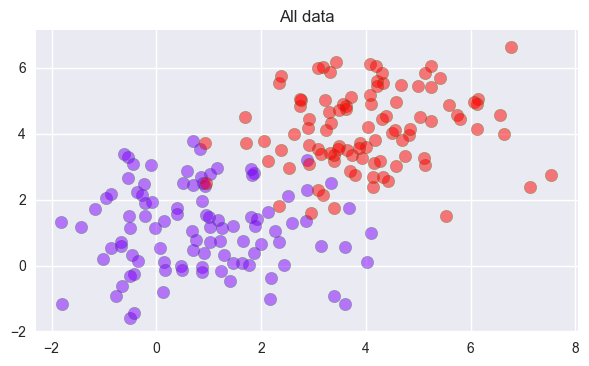

In [3]:
%matplotlib inline

import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (7.0, 4.0)
seaborn.mpl.rcParams['savefig.dpi'] = 100

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets.samples_generator import make_blobs

n_samples=200

centers = [(1, 1), (4, 4)]
X, Y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.3, centers=centers)

def plot_data(x, y, title):
    for this_y, color in zip(y_unique, colors):
        this_X = x[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1], s=80, c=color, alpha=0.5, 
                    label="Class %s" % this_y, edgecolors='g', marker="o")
#         plt.scatter(this_X[:, 0], this_X[:, 1], s=20, marker="x", c='k')
    plt.title(title)

plt.figure()
y_unique = np.unique(Y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
plot_data(X, Y, "All data")

### Эксперименты

Разделим все данные на тестовую и тренировочную выборки и обучим нашу модель на тренировочной.

In [4]:
from sklearn.model_selection import train_test_split

X_test, X_train, y_test, y_train = train_test_split(X, Y, test_size=0.5, random_state=42)

model = SvcModel()
model.fit(X_train, y_train * 2 - 1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.13033881018578
            Iterations: 8
            Function evaluations: 827
            Gradient evaluations: 8


Можем взглянуть на параметры разделяющей гиперплоскости:

In [5]:
print("W = %s" % model.W)
print("W_0 = %s" % model.W_0)

W = [ 1.04222506  1.15743221]
W_0 = 6.07213965634


Сначала посчитаем значения разделяющей прямой, чтобы ее рисовать.

In [6]:
z = np.linspace(-6, 10, 100)
bound = (model.W_0 - model.W[0] * z) / model.W[1]

Посмотрим как разделились тренировочные данные.

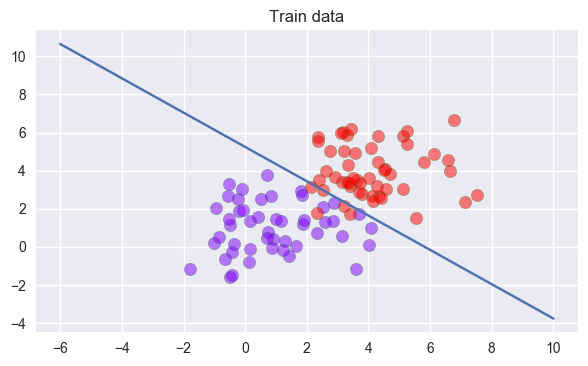

In [7]:
plt.figure()
plot_data(X_train, y_train, "Train data")
p = plt.plot(z, bound)

Теперь посмотрим как разделились тестовые данные.

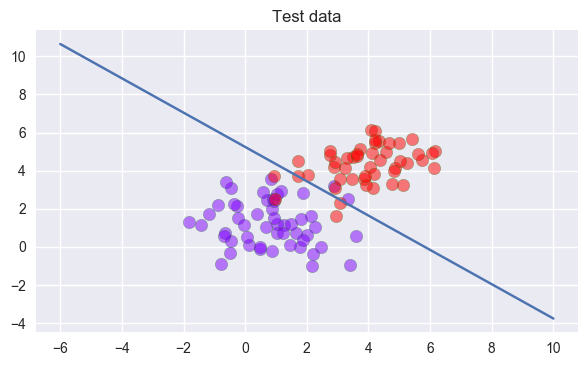

In [8]:
plt.figure()
plot_data(X_test, y_test, "Test data")
p =plt.plot(z, bound)

Добавим функцию для отрисовки confusion matrix (взято из [примера](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py))



In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Предскажем значения для тестовой выборки и нарисуем матрицу

Confusion matrix, without normalization
[[50  2]
 [ 5 43]]


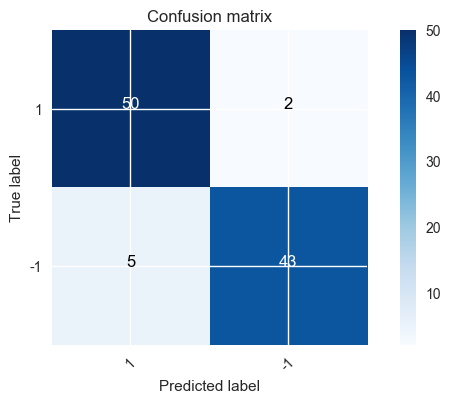

In [10]:
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test * 2 - 1, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["1", "-1"], title='Confusion matrix')
plt.show()

### Проверка модели в полевых условиях.

Попробуем обучить модель не на синтетических данных. Для этого будем использовать набор данных [Titanic](https://www.kaggle.com/c/titanic) для предсказания выжил пассажир или нет.

Загружаем данные:

In [11]:
import pandas as pd

data = pd.read_csv("train_titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Для обучение будем использовать следующие признаки: Pclass (класс), Sex (пол), Age (возраст), Fare (цена билета). Будем работать с выборкой из 400 человек. 200 будем использовать для обучения, 200 для тестирования (иначе очень долго считает). После отмаштабируем данные, пропуски просто выбросим

In [12]:
df = data[["Pclass", "Sex", "Age", "Fare", "Survived"]].dropna().sample(400)
df["Pclass"] = (df["Pclass"] - df["Pclass"].min()) / (df["Pclass"].max() - df["Pclass"].min())
df["Sex"] = df["Sex"].apply(lambda sex: 1 if sex == "male" else -1)
df["Age"] = (df["Age"] - df["Age"].min()) / (df["Age"].max() - df["Age"].min())
df["Fare"] = (df["Fare"] - df["Fare"].min()) / (df["Fare"].max() - df["Fare"].min())
df["Survived"] = df["Survived"].apply(lambda s: 1 if s == 1 else -1)

data_matrix = df.as_matrix()
X = data_matrix[0:, 0:-1]
Y = data_matrix[0:, -1]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

titanic_model = SvcModel()
titanic_model.fit(X_train, y_train)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.49999947774795
            Iterations: 13
            Function evaluations: 2641
            Gradient evaluations: 13


Отлично! Попробуем предсказать живучесть пассажиров на тестовой выборке.

In [14]:
prediction = titanic_model.predict(X_test)

Confusion matrix, without normalization
[[108  15]
 [ 21  56]]


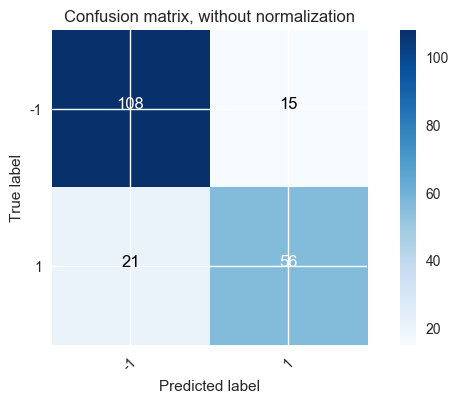

In [15]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, prediction)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["-1", "1"], title='Confusion matrix')
plt.show()

Посчитаем точность предсказания:

In [20]:
from sklearn.metrics import accuracy_score

print("Accuracy = %5.2f" % accuracy_score(y_test, prediction))

Accuracy =  0.82


In [21]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Precision = tp / (tp + fp) = %5.2f" % precision_score(y_test, prediction))
print("Precision = tp / (tp + fn) = %5.2f" % recall_score(y_test, prediction))

Precision = tp / (tp + fp) =  0.79
Precision = tp / (tp + fn) =  0.73


### Вывод

Мы получили работающую реализацию модели SVC, которая позволила быстро соорудить достаточно точный классификатор реальных данных. 